# **Cloud Computing: Can you predict the monthly cloud bill for startups in Austin?**

**Cloud Computing**:  a model for enabling on-demand network access to a shared 
pool of computing resources (e.g., networks, servers, storage, applications, 
and services) that can be rapidly provisioned and released with minimal management 
effort or service provider interaction.  

**5 Key Characteristics of Cloud Computing**

> 1. Broad Network Access
> 2. Measured Service
> 3. On Demand Self Service
> 4. Shared Resource Pooling
> 5. Rapid Elasticity

**3 Service Models**

> 1. **Software as a Service (SaaS)**: Provider’s applications running on a cloud infrastructure

> 2. **Platform as a Service (PaaS)**: Consumer-created or acquired applications created using tools supported by the provider

> 3. **Infrastructure as a Service (IaaS)**: Consumer is able to deploy and run arbitrary software on storage, networks, etc.

**Amazon Web Services (AWS)**  
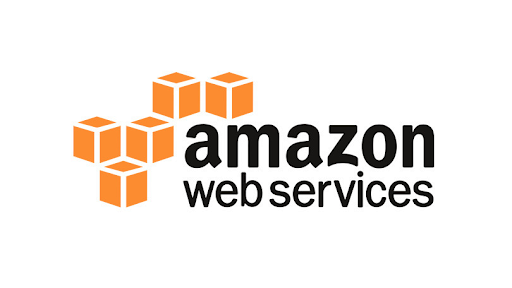

## Cloud Management

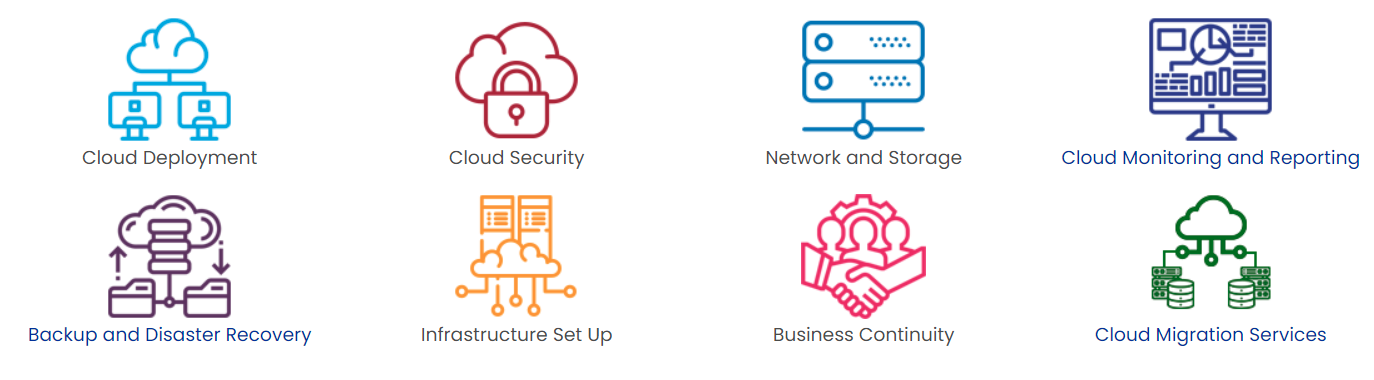

**MultiCloudX**: Austin based start-up that functions as a third-party cloud manager to manage cloud storage, operations, and costs

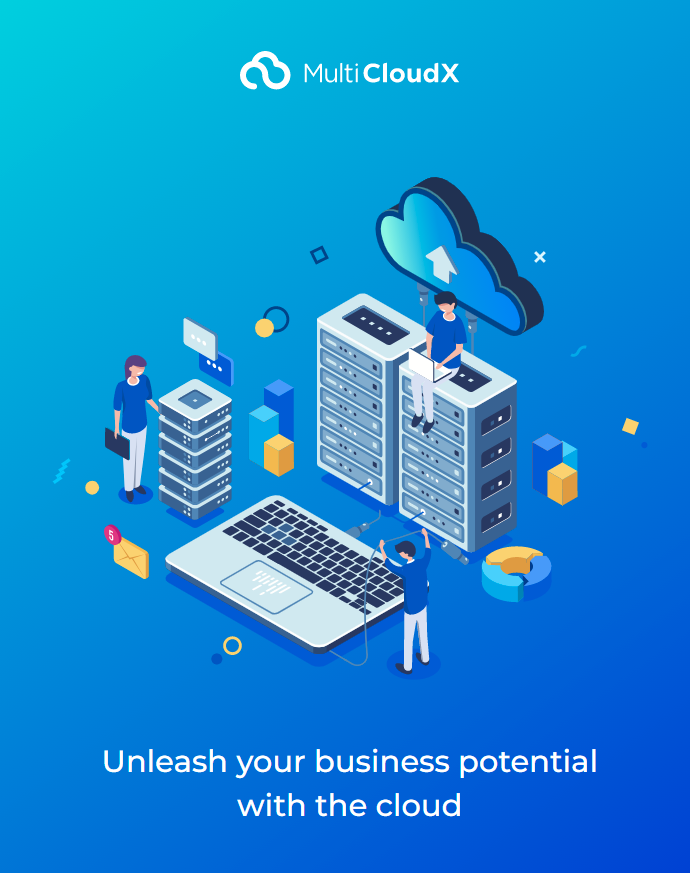

### Import Statements

In [1]:
# Data processing
import numpy as np
import pandas as pd
import datetime as dt

# Graphics libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn metrics and processing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Keras/Tensorflow modules
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

### Import Data

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
dfCCO = pd.read_csv(r".\Data\cco_cost_monthly.csv")

In [4]:
dfPYCO = pd.read_csv(r".\Data\pyco_cost_monthly.csv", low_memory=False)

In [5]:
dfXCO = pd.read_csv(r".\Data\xco_cost_monthly.csv")

In [6]:
dfCCO.head()

,cloud_resource_id,usage_account_id,billing_account_id,provider_code,usage_amount,currency_code,tax,sub_total,total_cost,system_currency_code,conversion_rate,converted_total_cost,product_name,service_code,service_name,product_sku,availability_zone,location_id,usage_type,usage_type_group,cost_type,instance_type,blended_rate,unblended_rate,unblended_cost,category,clock_speed,from_location,to_location,transfer_type,pricing_rate_id,public_ondemand_cost,public_ondemand_rate,pricing_term,pricing_unit,memory,operating_system,vpcu,phsyical_processor,volume_type,storage,storage_class,storage_media,invoice_month
0,NaN,751355800400,751355800400,aws,1.0,USD,0.0,0.0,0.03,USD,1.0,0.03,Elastic Load Balancing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tax,NaN,0.0,0.0,0.03,Unknown,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01
1,NaN,751355800400,751355800400,aws,2.0,USD,0.0,0.0,0.07,USD,1.0,0.07,Amazon Elastic Compute Cloud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tax,NaN,0.0,0.0,0.07,Unknown,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01
2,NaN,751355800400,751355800400,aws,1.0,USD,0.0,0.0,0.00,USD,1.0,0.00,Amazon Simple Storage Service,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tax,NaN,0.0,0.0,0.00,Unknown,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01
3,arn:aws:kms:us-east-1:751355800400:key/5fedb8a...,751355800400,751355800400,aws,18.0,USD,0.0,0.0,0.00,USD,1.0,0.00,AWS Key Management Service,awskms,AWS Key Management Service,MFEBZPX8NHM5FY7Z,NaN,us-east-1,us-east-1-KMS-Requests,awskms-APIRequest-All,Usage,NaN,0.0,0.0,0.00,API Request,NaN,NaN,NaN,NaN,1.698969e+09,0.000054,0.000003,NaN,Requests,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01
4,arn:aws:cognito-idp:us-east-1:751355800400:use...,751355800400,751355800400,aws,2.0,USD,0.0,0.0,0.00,USD,1.0,0.00,Amazon Cognito,AmazonCognito,Amazon Cognito,QJC3UE86XSTPJMMZ,NaN,us-east-1,USE1-CognitoUserPoolsMAU,NaN,Usage,NaN,0.0,0.0,0.00,User Pool MAU,NaN,NaN,NaN,NaN,1.760619e+09,0.011000,0.005500,NaN,Requests,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01


In [7]:
dfSample = dfCCO.loc[dfCCO.invoice_month > "2021-01-01"]

In [8]:
dfSample.to_csv(".\CCO_Jan_Feb_2021.csv", index=False)

___
**Now we combine all 3 company's datasets to get a look at some statistics that we can generalize across all 3 companies for our feature engineering.**
___

In [9]:
def plot_corr(dataframe,size=10):
    """
    Plots a correlation matrix as a heat map 
    """
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0, cmap = "bwr")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation = 90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')

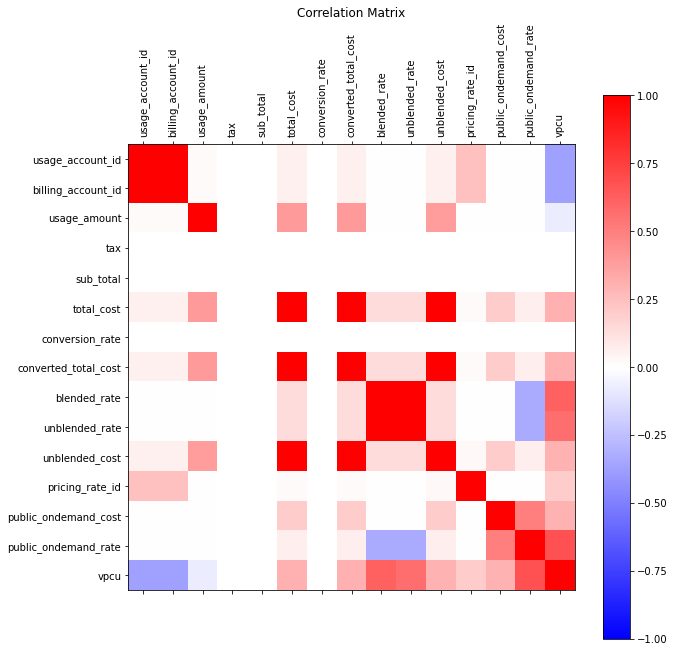

In [10]:
dfTotal = pd.concat([dfCCO, dfPYCO, dfXCO], axis=0)
plot_corr(dfTotal)

**We gain little information from this heatmap. We can't get a strong idea of what's driving cost and we will need to do feature engineering to better see the quantititative correlations of our datasets.**

____
## Plotting
Now, let's make some figures to get an idea of how the big hitter services are affecting costs month over month.

In [11]:
def hitter_monthly(df, product):
    """
    Grabs the total cost incurred by the big hitter (product) for each month of the DataFrame, df
    """
    dfFin = df.loc[df["product_name"] == product].groupby("invoice_month").agg({"total_cost": "sum"})
    return dfFin

In [12]:
def plot_n_hitters(n_hitters):
    """
    Plots the N biggest overall hitters and the aggregate cost
    """
    top_hitters = dfTotal.groupby("product_name").agg({"total_cost": "sum"}).sort_values("total_cost", ascending=False).index[:n_hitters]
    company_dfs = [dfXCO, dfPYCO, dfCCO]
    company_names = ["XCO", "PYCO", "CCO"]
    final_df_list = []
    fig, ax = plt.subplots(3,2, figsize=(14, 8.5))
    for index in range(len(company_names)):
        inter_list = []

        for hitter in range(len(top_hitters)):
            new_monthly_df = hitter_monthly(company_dfs[index], top_hitters[hitter])
            ax[index][0].plot(new_monthly_df)
            ax[index][0].tick_params("x", rotation=90)
            inter_list.append(new_monthly_df)


        ax[index][0].set_title(str(company_names[index]) + " Big Hitters Monthly Cost")
        ax[index][0].legend(top_hitters, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        final_df_list.append(inter_list)
        agg_df = company_dfs[index].groupby("invoice_month").agg({"total_cost": "sum"})
        ax[index][1].plot(agg_df, color="red")
        ax[index][1].set_title(str(company_names[index]) + " Total Monthly Cost")
        ax[index][1].tick_params("x", rotation=90)

    fig.tight_layout()    
    fig.savefig(r".\figures\graphs_mod" + str(n_hitters) + ".png")
    return final_df_list

In [13]:
def plot_n_hitters_bycorp(n_hitters):
    """
    Plots the top N big hitters on a company-by-company basis (possibly different for each company)
    """
    company_dfs = [dfXCO, dfPYCO, dfCCO]
    company_names = ["XCO", "PYCO", "CCO"]
    final_df_list = []
    fig, ax = plt.subplots(3,2, figsize=(14, 8.5))
    for index in range(len(company_names)):
        inter_list = []
        top_hitters = company_dfs[index].groupby("product_name").agg({"total_cost": "sum"}).sort_values("total_cost", ascending=False).index[:n_hitters]
        
        for hitter in range(len(top_hitters)):
            new_monthly_df = hitter_monthly(company_dfs[index], top_hitters[hitter])
            ax[index][0].plot(new_monthly_df)
            ax[index][0].tick_params("x", rotation=90)
            inter_list.append(new_monthly_df)


        ax[index][0].set_title(str(company_names[index]) + " Big Hitters Monthly Cost")
        ax[index][0].legend(top_hitters, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        final_df_list.append(inter_list)
        agg_df = company_dfs[index].groupby("invoice_month").agg({"total_cost": "sum"})
        ax[index][1].plot(agg_df, color="red")
        ax[index][1].set_title(str(company_names[index]) + " Total Monthly Cost")
        ax[index][1].tick_params("x", rotation=90)

    fig.tight_layout()    
    fig.savefig(r".\figures\company_hitters_" + str(n_hitters) + ".png")

In [14]:
products = dfTotal["product_name"].unique()

In [15]:
products

array(['Elastic Load Balancing', 'Amazon Elastic Compute Cloud',
       'Amazon Simple Storage Service', 'AWS Key Management Service',
       'Amazon Cognito', 'AmazonCloudWatch',
       'Amazon EC2 Container Service', 'Amazon QuickSight',
       'Amazon Simple Queue Service',
       'Amazon Elastic Container Service for Kubernetes',
       'AWS Data Transfer', 'AWS Lambda', 'Amazon Elastic File System',
       'Amazon Simple Notification Service', 'AWS Config',
       'Amazon Relational Database Service', 'AWS Glue',
       'AWS Secrets Manager', 'Amazon Athena', 'Amazon ElastiCache',
       'Amazon Simple Email Service',
       'Amazon EC2 Container Registry (ECR)', 'AWS Support (Developer)',
       'AWS Data Pipeline', 'Amazon Route 53',
       'Cyber Security Cloud Managed Rules for AWS WAF -API Gateway/Serverless-',
       'AWS CloudTrail', 'Amazon CloudFront', 'AWS WAF',
       'Amazon API Gateway', 'AWS Cost Explorer', 'Amazon DynamoDB',
       'AWS Support (Business)', 'Amazon 

____
The first plot here is a demonstration of how the top 5 overall "big hitters" affect the aggregate cost (right) for each company. We can see that the top 5 big hitters aren't necessarily the biggest cost drivers for each company. Another interesting insight is how for XCO, the graphical shape seems to be driven more by Amazon DocumentDB even though it's not the largest charge most months, it is the biggest contributor of variance.
____

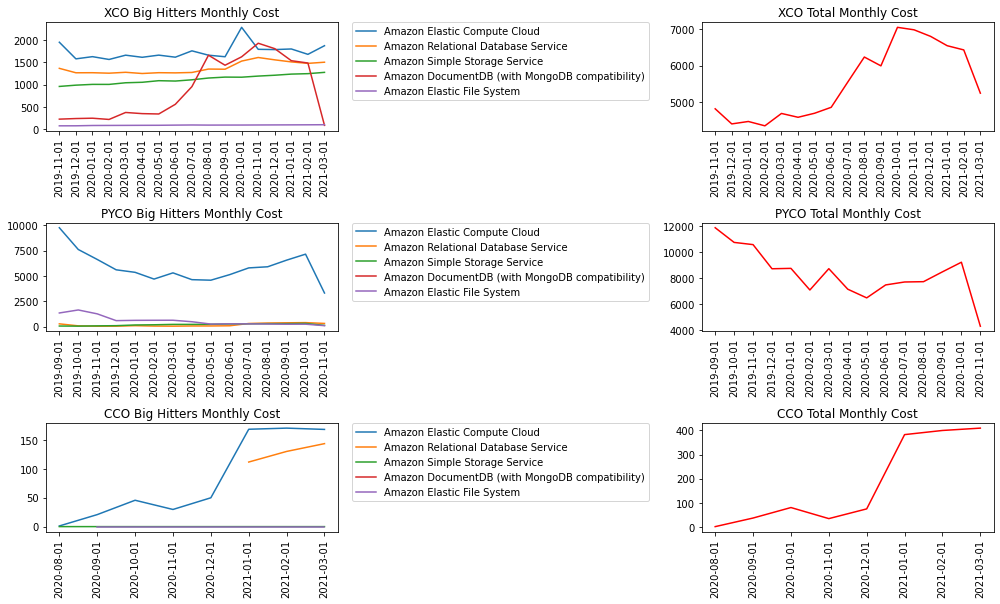

In [16]:
top_5 = plot_n_hitters(5)

____
Here, we look at the top 5 top "big hitters" on a company-by-company basis and see that there were a lot of costs that matter to company with a smaller cloud footprint, like CCO that don't necessarily affect a relatively larger corporation like PYCO.
____

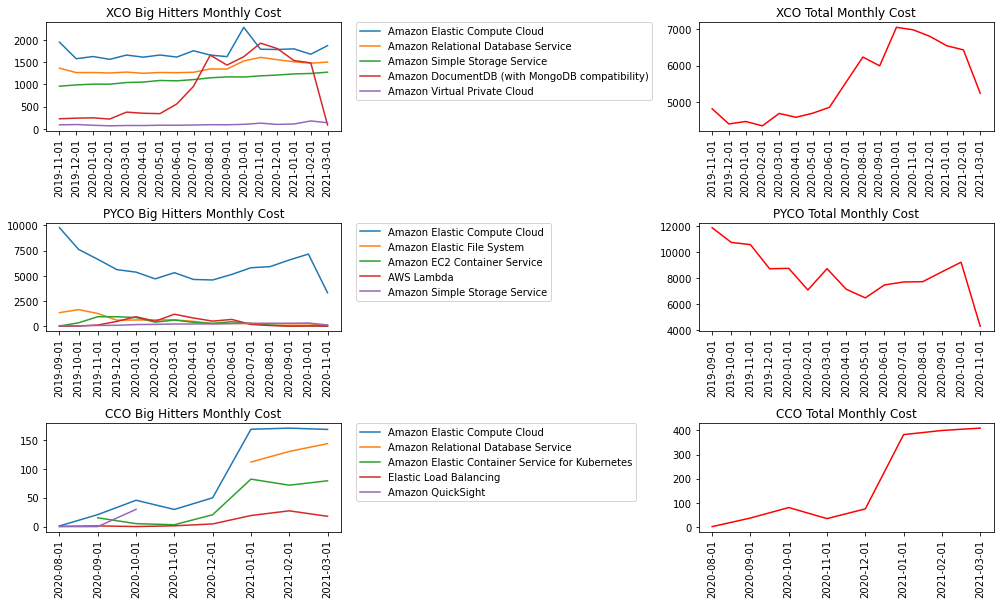

In [17]:
plot_n_hitters_bycorp(5)

## Data Processing

**Now we will process our data's into usable features for a time series regression model. We for each month, we take 3 main things:**
1. Total Cost
2. Total Cost by product
3. Total Usage by product

In [18]:
def process_dataframe(df, fillna=True):
    """
    Processes a dataFrame from what's initially given to a usable form for our model.
    """
    dfProcessed = df.groupby("invoice_month").agg({"total_cost": "sum"})
    products = dfTotal["product_name"].unique()
    # Loops through all of the unique product names
    for product in products:
        # Grabs the monthly total cost and usage for each product
        df_product_monthly = df.loc[df["product_name"] == product].groupby("invoice_month").agg({"total_cost": "sum", "usage_amount": "sum"}).rename(columns={"total_cost" : product + " cost", "usage_amount": product + " usage"})
        #Concatenates that onto the total dataframe we have
        dfProcessed = pd.concat([dfProcessed, df_product_monthly], axis=1)
    if fillna==True:    
        dfProcessed = dfProcessed.fillna(0)
    dfProcessed.index = pd.to_datetime(dfProcessed.index)
    return dfProcessed

In [43]:
dfCCO_processed = process_dataframe(dfCCO, fillna=True)
dfCCO_processed.tail(2).to_csv("score.csv", index=True)

### CCO 

Interesting things to note:

* The only negative correlations lie with the Amazon Elastic File System

* Cost variance seems to be driven strongly by many different services. Likely points to a ramping up of cloud costs, which was reflected in our earlier plots

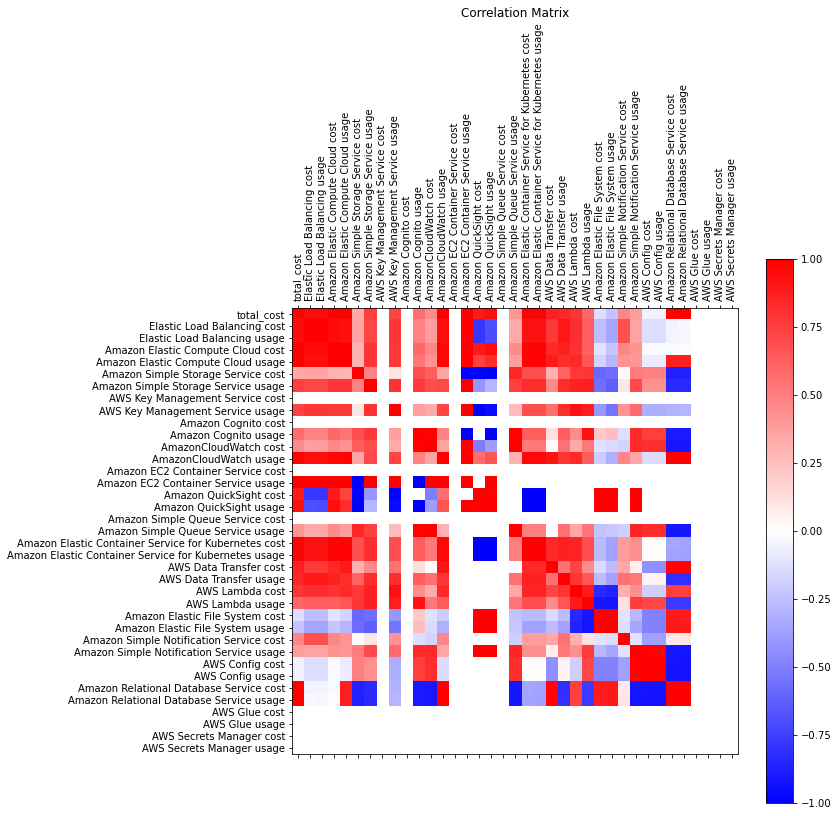

In [20]:
# CCO Correlation Matrix
plot_corr(dfCCO_processed.dropna(axis=1, how="all"))

### PYCO

Interesting things to note:  

* There's a somewhat large amount of negative correlations for cost, but none are very strong.

* The strongest correlation seems to lie with Amazon Elastic File System costs

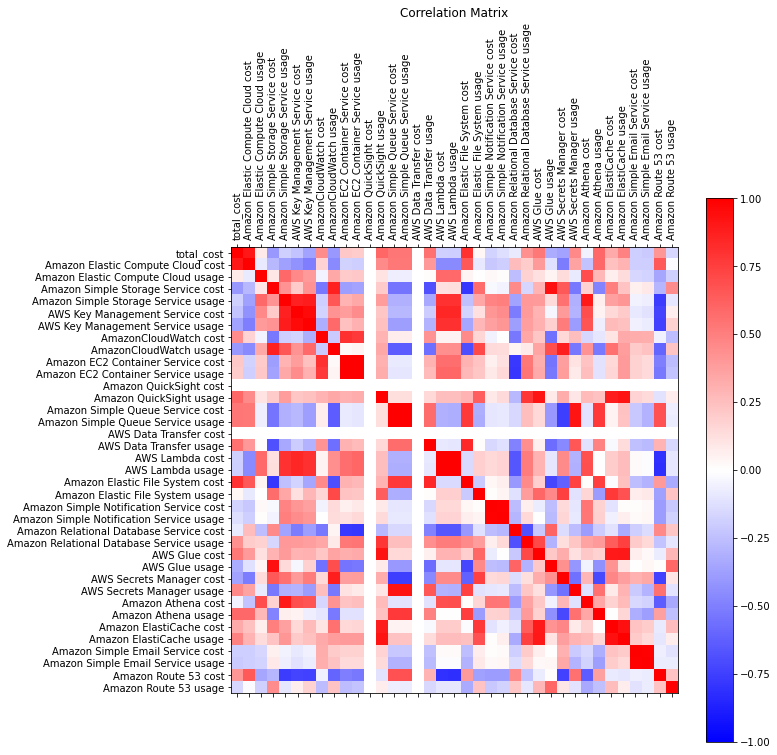

In [21]:
dfPYCO_processed = process_dataframe(dfPYCO, fillna=False)
# PYCO Correlation Matrix
plot_corr(dfPYCO_processed.dropna(axis=1))

### XCO
Interesting points to note:  

* Amazon Lightsail cost has a fairly strong negative correlation with total cost.  

* Amazon Relational DB Cost, Amazon simple storage, and Amazon DocumentDB are cost variance drivers. This seems to be a company that intakes a good amount of data and the data intake seems to correlate with increasing costs.

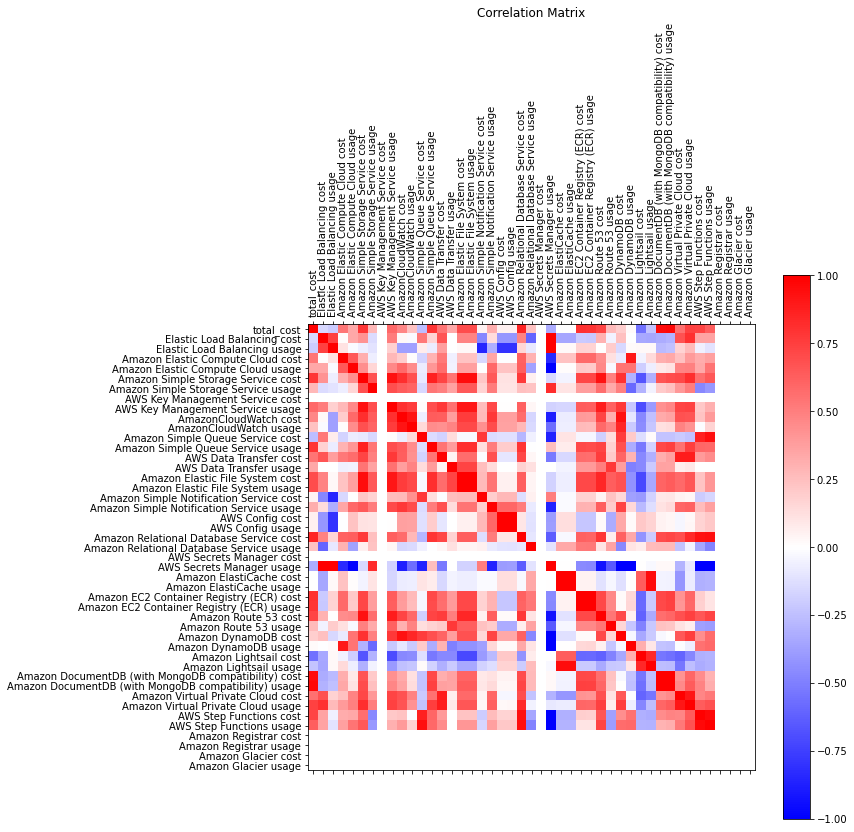

In [22]:
dfXCO_processed = process_dataframe(dfXCO, fillna=False)
plot_corr(dfXCO_processed.dropna(axis=1, how="all"))

# Modelling

### Why LSTM?

* AR/MA models require hyperparameters tuned for each dataset and will not be deployable in the field if we need to 
* FB Prophet is not well-designed for data with many features beyond the explanatory variable driving itself and there's a focus on seasonality which is not very present in our datasets
* Holt-Winters Exponential Smoothing has lack of strength handling multivariate data

The following functions respectively have the role of:
1. Converting dataframes into time slice tensors
2. Creating a test/train split of our time series data predicated on an array of months whose target and associated features we'd like to keep in testing
3. A custom class with important features of our data processing and processed data as attributes

In [23]:
def to_supervised (df_for_training, n_future, n_past):
    """
    Creates a tensor from time series slices of n months with all features 
    """
    trainX = []
    trainY = []

    for i in range(n_past, len(df_for_training) - n_future +1):
        trainX.append(df_for_training[i - n_past:i, 0:df_for_training.shape[1]])
        trainY.append(df_for_training[i + n_future - 1:i + n_future, 0])

    trainX, trainY = np.array(trainX), np.array(trainY)
    
    return trainX, trainY

In [24]:
def CustomSplit(X, y, locations):
    """
    Splits tensors in a custom list of locations
    """
    test_X = X[locations]
    train_X = np.delete(X, locations, axis=0)
    test_y = y[locations]
    train_y = np.delete(y, locations, axis=0)
    
    return train_X, test_X, train_y, test_y

In [25]:
class CustomTensorData:
    def __init__(self, df, locations, n_future, n_past, name):
            self.df = process_dataframe(df, fillna=True)
            self.months = self.df.index
            self.ss = StandardScaler()
            dfScaled = self.ss.fit_transform(self.df)
            X, y = to_supervised(dfScaled, n_future, n_past)
            self.train_X, self.test_X, self.train_y, self.test_y =  CustomSplit(X, y, locations)
            self.name = name
            self.split_locations = locations
            self.n_past = n_past

___
Now we will instantiate the objects for each dataset and can observe the shape of each tensor, which is in the format **(slices, window depth, features)** We removed some random points for each company to see how it would perform for each of them
___

In [26]:
PYCO_custom = CustomTensorData(dfPYCO, [1, 3, 6], 1, 2, "PYCO")
CCO_custom = CustomTensorData(dfCCO, [1, 4], 1, 2, "CCO")
XCO_custom = CustomTensorData(dfXCO, [1, 5, 8], 1, 2, "XCO")

___
We combine all 3 companies for a total train_X and a total train_y so that we can train the model on the trends of all 3 companies. Additionally, improved accuracy was found when feeding in each company twice into our model to train.
___

In [27]:
train_X_combined = np.concatenate((PYCO_custom.train_X, XCO_custom.train_X, CCO_custom.train_X, PYCO_custom.train_X, XCO_custom.train_X, CCO_custom.train_X), axis = 0)
train_Y_combined = np.concatenate((PYCO_custom.train_y, XCO_custom.train_y, CCO_custom.train_y, PYCO_custom.train_y, XCO_custom.train_y, CCO_custom.train_y), axis = 0)

___
Now, we build our LSTM model. Additional details on our layers and processes for ensuring a reasonable train time can be given upon request.
___

In [28]:
def build_model (trainX, trainY, epoch, bs):
    
    
    model = Sequential()
    model.add(LSTM(16, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    model.add(LSTM(8, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(trainY.shape[1]))

    model.compile(optimizer='adam', loss='mse') #custom loss function, l2/l1 regularization
    model.summary()
    
    es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1)
    mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

    tb = TensorBoard('logs')

    history = model.fit(trainX, trainY, shuffle=True, epochs= epoch, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size= bs)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2, 16)             7168      
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 7,977
Trainable params: 7,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1/3 [=========>....................] - ETA: 0s - loss: 1.1576WARNING:tensorflow:From C:\Users\irvin\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and wil

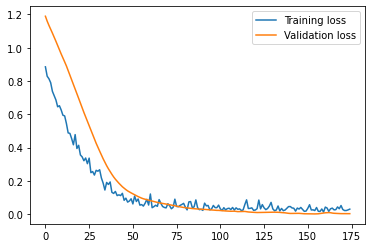

In [29]:
model_HUGE = build_model(train_X_combined, train_Y_combined, 200, 16)

In [30]:
model_HUGE.save(".\Model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: .\Model\assets


In [31]:
test_output = model_HUGE.predict(PYCO_custom.test_X)

___
Now that we have a model built and trained we can fit our data on our test sets and see how the performance looks
___

In [32]:
def custom_evaluate_predictions(model, company):
    """
    Takes final predictions and compares them graphically and statistically against the true values
    """
    
    forecast = model.predict(company.test_X)
    
    forecast_copies = np.repeat(forecast, company.test_X.shape[2], axis=-1)
    forecast = company.ss.inverse_transform(forecast_copies)[:,0]
    
    y_copies = np.repeat(company.test_y, company.test_X.shape[2], axis=-1)
    y = company.ss.inverse_transform(y_copies)[:,0]
    future_time = company.months[[x + company.n_past for x in company.split_locations]]

    
    print(future_time)
    
    plt.title(company.name + " Test Set Validation")
    plt.xticks(rotation=90)
    plt.plot(company.df.total_cost, '-o', label="Original")
    plt.scatter(future_time, forecast, label="Predictions", color="red")
    plt.legend()
    plt.show();

    print("MSE:", mean_squared_error(forecast, y)) 
    print("MAE: ", mean_absolute_error(forecast, y))
    print("RMSE: ", (mean_squared_error(forecast, y))**.5)
    
    return

Now, to evaluate our models in real time:

DatetimeIndex(['2019-12-01', '2020-02-01', '2020-05-01'], dtype='datetime64[ns]', name='invoice_month', freq=None)


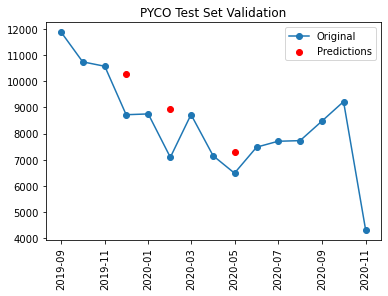

MSE: 2119838.565276152
MAE:  1388.2773558339597
RMSE:  1455.966539888933


In [33]:
custom_evaluate_predictions(model_HUGE, PYCO_custom)

DatetimeIndex(['2020-02-01', '2020-06-01', '2020-09-01'], dtype='datetime64[ns]', name='invoice_month', freq=None)


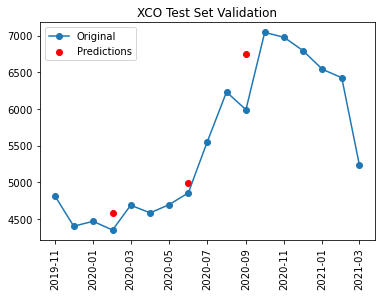

MSE: 214170.07657389456
MAE:  374.28289411193964
RMSE:  462.78513002677016


In [34]:
custom_evaluate_predictions(model_HUGE, XCO_custom)

DatetimeIndex(['2020-11-01', '2021-02-01'], dtype='datetime64[ns]', name='invoice_month', freq=None)


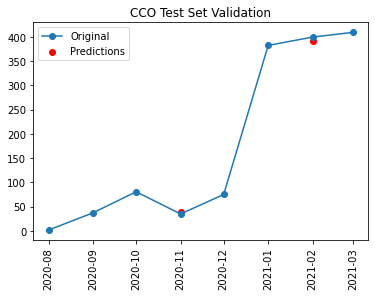

MSE: 37.22396174465651
MAE:  5.987062377953151
RMSE:  6.101144297970382


In [35]:
custom_evaluate_predictions(model_HUGE, CCO_custom)

# Future Forecast

In [36]:
def forecaster(company, model):
    timeframe = company.ss.transform(company.df.tail(company.n_past).to_numpy())
    tensor = timeframe.reshape((1, company.n_past, 95))
    
    forecasted_value = model.predict(tensor)
    forecast_copies = np.repeat(forecasted_value, 95, axis=-1)
    
    costs = company.df.total_cost
    new_month = dt.date(costs.index[-1].year, costs.index[-1].month + 1, 1)
    prediction = pd.Series(company.ss.inverse_transform(forecast_copies)[:, 0], index=[new_month])
    prediction.index = pd.to_datetime(prediction.index)
        
    plt.title(company.name + " Forecast")
    plt.xticks(rotation=90)
    plt.plot(costs, '-o', label="Original")
    plt.scatter(prediction.index, prediction.iloc[0], label="Forecast", color="red")
    plt.legend()
    plt.show()    

In [37]:
from joblib import dump, load

In [38]:
dump(CCO_custom.ss, "scaler.joblib")

['scaler.joblib']

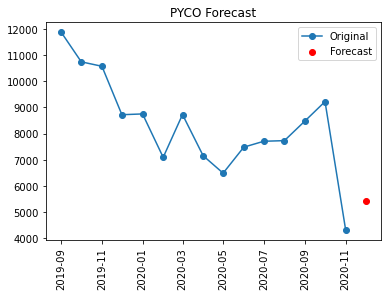

In [39]:
forecaster(PYCO_custom, model_HUGE)

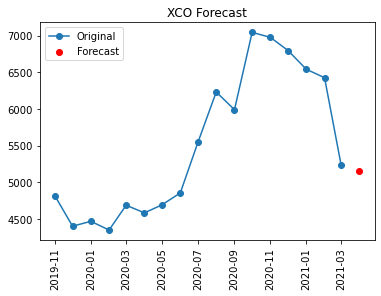

In [40]:
forecaster(XCO_custom, model_HUGE)

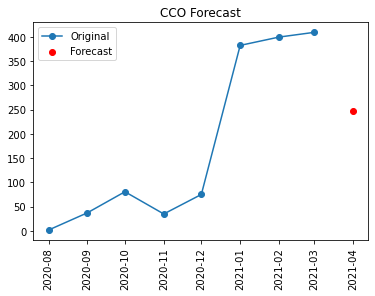

In [41]:
forecaster(CCO_custom, model_HUGE)